In [41]:
import os
import sys
sys.path.append("../")
import tensorflow as tf
from glob import glob
from typing import List, Tuple
#from .data_processing.data_loader import dataset_loader
#from rosbag2numpy.data_processing.data_loader_costmap  import dataset_loader
from rosbag2numpy.data_processing.data_loader_dual_costmap  import dataset_loader

from matplotlib import pyplot as plt
import numpy as np
from numpy import ndarray
from typing import Dict, List, Union
from rosbag2numpy.config import params
from rosbag2numpy.config import generalization_model_params as g_params
import wandb
from wandb.keras import WandbCallback
from rosbag2numpy.losses import euclidean_distance_loss,enc_costmap_loss
from rosbag2numpy.models import LSTMconv1x1_with_encoder
import time
import os
from rosbag2numpy.train import get_np_test_ds
from tensorflow.keras import backend as K
from rosbag2numpy.train import get_np_test_ds, cd_wand_custom
from misc import plot_scene

print(tf.__version__)
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

2.3.0


In [42]:
ds_loader = dataset_loader(
    tfrec_dir=params.get("dataset_dir"),
    batch_size=params.get("H_BATCH_SIZE"),
    shuffle_buffer=params.get("H_SHUFFLE_BUFFER"),
    normalize_coords=params.get("normalize_coords"),
    normalize_factor=params.get("normalize_factor")
)
ds_train, ds_valid, ds_test = ds_loader.build_scenario_dataset(consider_scenes=10,no_train_scene=8,no_valid_scene=1,no_test_scene=1)

Scenarios:['/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_costmap_dist_dir/scenario1', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_costmap_dist_dir/scenario2', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_costmap_dist_dir/scenario3', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_costmap_dist_dir/scenario4', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_costmap_dist_dir/scenario5', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_costmap_dist_dir/scenario_ph_11', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_costmap_dist_dir/scenario_ph_12', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_costmap_dist_dir/scenario_ph_13', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_costmap_dist_dir/scenario_ph_14', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_costmap_dist_dir/scenario_ph_15']
Building Dataset.......

Number of records, Train files:610, validation files:109, Test Files:

In [43]:
#model = conv1x1_endpoint_in_model_costmapout.nn(full_skip= True,params=params)
model = LSTMconv1x1_with_encoder.nn(full_skip = True, params = params)
# Learning rate scheduler

#lrs = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=params.get("lr"), decay_steps=params.get("lr_decay_steps"), decay_rate=params.get("lr_decay_rate"))
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=.02, decay_steps=10000, decay_rate=.1)
opt = LSTMconv1x1_with_encoder._get_optimizer(params.get("optimizer"), lr=learning_rate)

model.compile(
    optimizer=opt,
    loss=params.get("losses"),
    loss_weights=params.get("loss_weights"),
    metrics=params.get("metric")
)

cb_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=3, min_lr=0.0001
)

Model: "functional_13"
________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
input_7 (InputLayer)                   [(None, 1536, 1536, 1)]    0                                                     
________________________________________________________________________________________________________________________
Left_boundary (InputLayer)             [(None, 25, 2)]            0                                                     
________________________________________________________________________________________________________________________
Right_boundary (InputLayer)            [(None, 25, 2)]            0                                                     
________________________________________________________________________________________________________________________
Initial_p

In [44]:
def grad(model,inputs,targets):
    with tf.GradientTape() as tape:
        enc_costmap,preds = model(inputs)
        loss_value = euclidean_distance_loss(preds,targets)
        total_loss = K.sum(K.flatten(tf.abs(enc_costmap * tf.abs(targets-preds))))#loss_value #+ K.sum(K.flatten(tf.abs(enc_costmap * tf.abs(targets-preds))))
    return total_loss, tape.gradient(loss_value, model.trainable_variables)

In [45]:
## Note: Rerunning this cell uses the same model variables

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

val_loss_results = []
val_accuracy_results = []

num_epochs = 50

loss_weight = 1

for epoch in range(num_epochs):
    start = time.time()
    epoch_loss_avg = tf.metrics.Mean()
    epoch_accuracy = tf.metrics.MeanAbsoluteError()

    # Training loop - using batches of 32
    for x, y in ds_train:
        # Optimize the model
        loss_value, grads = grad(model, x, y)
        opt.apply_gradients(zip(grads, model.trainable_variables))

        # Track progress
        epoch_loss_avg.update_state(loss_value)  # add current batch loss
        # compare predicted label to actual label
        epoch_accuracy.update_state(y, model(x,training=True))
        #epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)

    # end epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    
    #print("Epoch {:03d}: Loss: {:.4f}, Acc: {:.4%}".format(epoch,epoch_loss_avg.result(),epoch_accuracy.result()))

    ##################### Per epoch Validation and testing #############################
    validation_loss_avg = tf.metrics.Mean()
    validation_accuracy = tf.metrics.MeanAbsoluteError()
    #validation 
    for (x, y) in ds_valid:
        # Track progress
        val_costmap,val_preds = model(x,training=False)
        val_loss = K.sum(K.flatten(K.abs(val_costmap * K.abs(y-val_preds))))#euclidean_distance_loss(val_preds,y) #+ K.sum(K.flatten(K.abs(val_costmap * K.abs(y-val_preds))))
        validation_loss_avg.update_state(val_loss)  # add current batch loss
        # compare predicted label to actual label
        validation_accuracy.update_state(y, val_preds)

    val_loss_results.append(validation_loss_avg.result())
    val_accuracy_results.append(validation_accuracy.result())

    print(f"Epoch {epoch+1:03d}: Loss: {epoch_loss_avg.result():.5f}, Acc: {epoch_accuracy.result():.4f},\
        Val loss: {validation_loss_avg.result():.4f}, Val Acc: {validation_accuracy.result():.4f}. time:{time.time()-start:0.3f}")

    """
    for (x, y) in ds_test.take(1):
        test_preds = model(x)
        #test_preds = test_preds.numpy()
        #y = y.numpy()

        test_idx = 0

        #y = y[idx]

        test_data = {
        "grid_map": x[0].numpy()[test_idx],
        "grid_org_res": x[1].numpy()[test_idx],
        "left_bnd": x[2].numpy()[test_idx],
        "right_bnd": x[3].numpy()[test_idx],
        "car_odo": x[4].numpy()[test_idx],
        "init_path": x[5].numpy()[test_idx],
        "opt_path": y.numpy()[test_idx],
        "predictions": test_preds.numpy()[test_idx],
        "file_details": x[6].numpy()[test_idx],
        "testidx": test_idx,
        }
        #plot_scene(test_data, params.get("normalize_coords"), params.get("normalize_factor"))
    """
    #print(f"Val loss: {validation_loss_avg.result():.4f}, Val Acc: {validation_accuracy.result():.4f}")
        

Epoch 001: Loss: 0.06261, Acc: 0.2545,        Val loss: 0.0278, Val Acc: 0.0164. time:70.735
Epoch 002: Loss: 0.04272, Acc: 0.2503,        Val loss: 0.0288, Val Acc: 0.0154. time:70.505
Epoch 003: Loss: 0.03918, Acc: 0.2495,        Val loss: 0.0322, Val Acc: 0.0175. time:70.755
Epoch 004: Loss: 0.03493, Acc: 0.2486,        Val loss: 0.0199, Val Acc: 0.0108. time:70.829
Epoch 005: Loss: 0.07207, Acc: 0.2571,        Val loss: 0.0288, Val Acc: 0.0170. time:70.576
Epoch 006: Loss: 0.03443, Acc: 0.2486,        Val loss: 0.0271, Val Acc: 0.0148. time:70.894
Epoch 007: Loss: 0.02850, Acc: 0.2471,        Val loss: 0.0129, Val Acc: 0.0075. time:71.183
Epoch 008: Loss: 0.02536, Acc: 0.2464,        Val loss: 0.0354, Val Acc: 0.0207. time:70.820
Epoch 009: Loss: 0.02237, Acc: 0.2457,        Val loss: 0.0181, Val Acc: 0.0109. time:71.167
Epoch 010: Loss: 0.02022, Acc: 0.2453,        Val loss: 0.0114, Val Acc: 0.0068. time:70.917
Epoch 011: Loss: 0.01856, Acc: 0.2449,        Val loss: 0.0239, Val Ac

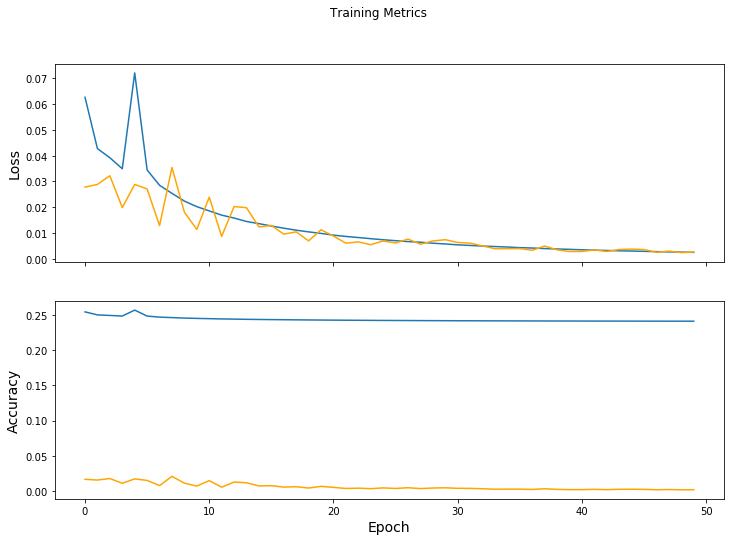

In [46]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)
axes[0].plot(val_loss_results, color="orange")
axes[0].legend(['train','val'], loc='upper right')

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
axes[1].plot(val_accuracy_results, color="orange")
axes[1].legend(['train','val'], loc='upper right')

plt.show()

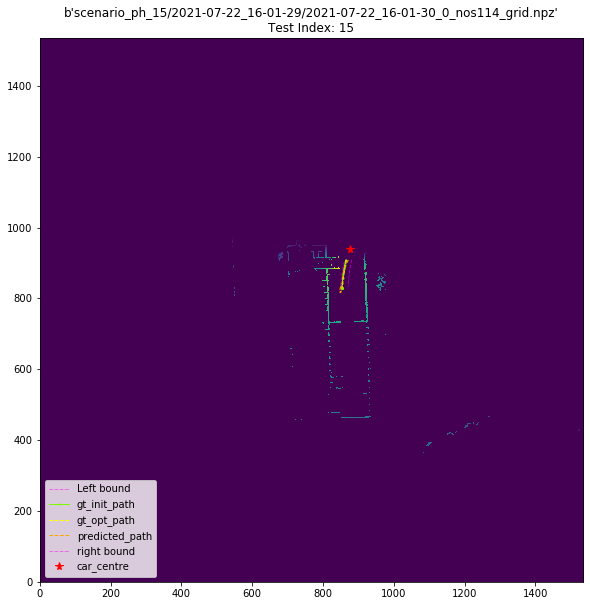

In [47]:
%matplotlib inline

for (x, y) in ds_test.take(1):
    _,test_preds = model(x)
 
    test_idx = 15

    #y = y[idx]

    test_data = {
    "grid_map": x[0].numpy()[test_idx],
    "grid_org_res": x[1].numpy()[test_idx],
    "left_bnd": x[2].numpy()[test_idx],
    "right_bnd": x[3].numpy()[test_idx],
    "car_odo": x[4].numpy()[test_idx],
    "init_path": x[5].numpy()[test_idx],
    "opt_path": y.numpy()[test_idx],
    "predictions": test_preds.numpy()[test_idx],
    "file_details": str(x[6].numpy()[test_idx]),
    "testidx": test_idx,
    }

    """    
    for keys,values in test_data.items():
        if keys=="grid_map":
            #plt.imshow(values,origin="lower")
            print(keys,np.max(test_data[keys]))
            print(type(test_data[keys]))
            plt.imshow(test_data[keys].astype(float),origin="lower")
            """
    
    plot_scene(test_data, params.get("normalize_coords"), params.get("normalize_factor"))
